In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import scipy.linalg
import h5py

plt.rcParams['axes.formatter.useoffset'] = False
plt.rcParams['figure.constrained_layout.use'] = True

# Greek alphabet: α, β, γ, δ, ε, ζ, η, θ, ι, κ, λ, μ, ν, ξ, ο, π, ρ, ς, σ, τ, υ, φ, χ, ψ, ω

# Constants
π = np.pi

In [2]:
# Functions
def recon_nonlinear(Field, Field_in, field, field_in, freqs, indices, order):
    # Angular frequency
    ω = 2*π * freqs
    
    # Create H-matrix
    col1 = (1.0j*ω*(Field/np.sqrt(gain) - Field_in/np.sqrt(att)))[indices]
    col2 = 1.0j*(Field/np.sqrt(gain) - Field_in/np.sqrt(att))[indices]
    col3 = (Field/np.sqrt(gain) - Field_in/np.sqrt(att))[indices]
    
    # Merge columns
    H = np.vstack((col1, col2, col3))
    
    # Non-linear damping terms
    for exp_ind, exp_val in enumerate(order):
        col = np.fft.fft((field/np.sqrt(gain) - field_in/np.sqrt(att))**(exp_val) )[indices] / len(field)
        H = np.vstack((H, col))
    
    # Making the matrix real instead of complex
    Hcos = np.real(H)
    Hsin = np.imag(H)
    H = np.hstack((Hcos, Hsin))
    
    # Normalize H for a more stable inversion
    Nm = np.diag(1. / np.max(np.abs(H), axis=1))
    H_norm = np.dot(Nm, H)  # normalized H-matrix
    
    # The drive vector, Q (from the Yasuda paper)
    Qcos = np.real(Field_in/np.sqrt(att))[indices]
    Qsin = np.imag(Field_in/np.sqrt(att))[indices]
    Qmat = np.hstack((Qcos, Qsin))
    
    # Solve system Q = H*p
    H_norm_inv = scipy.linalg.pinv(H_norm)
    p_norm = np.dot(Qmat, H_norm_inv)
    
    # Re-normalize p-values
    # Note: we have actually solved Q = H * Nm * Ninv * p
    # Thus we obtained Ninv*p and multiply by Nm to obtain p
    p = np.dot(Nm, p_norm)  # re-normalize parameter values
    
    # Forward calculation to check result, should be almost everything zero vector
    Q_fit = np.dot(p, H)
    
    # Scale parameters by drive force assuming known resonant frequency
    param_recon = p
    
    # Parameters reconstructed
    lambda_recon = 1 / param_recon[0]
    fr_recon = lambda_recon * param_recon[1] / (2*π)
    kappa_arr = lambda_recon * param_recon[2:]
    
    return lambda_recon, fr_recon, kappa_arr, Q_fit


def dBm(data):
    return 16.612 * np.log10(data) - 16.743


def W(data_dBm):
    return 10 ** ((data_dBm - 30) / 10)

In [7]:
verbose = False

# Load file
# file = r'D:\TLS\TLS-Data\TLS_IMP_amped_DCAW23_10amps_201points.hdf5'
file = r'D:\TLS\TLS-Data\TLS_IMP_amped_DCAW23_200amps_11points.hdf5'

# EXPERIMENTAL PARAMETERS
# Resonance frequency of the system
f_res = 4.1105253e9  # Hz
ω_res = 2 * np.pi * f_res

# Gain of the output line
gain = 80.5  # dB
gain_lin = 10 ** (gain / 10)
# Attenuation of the input line
att = 68.5  # dB
att_lin = 10 ** (att / 10)

# Open hdf5 file
with h5py.File(file, "r") as dataset:
    # Mixer frequency array
    fNCO_arr = np.asarray(dataset["mixer frequencies"])  # Hz
    # Pump amplitudes array 
    pamp_arr = np.asarray(dataset["signal amplitudes"])  # fsu
    # Amplitude in dBm
    pamp_dBm_arr = dBm(pamp_arr)
    # Amplitude in W
    pamp_W_arr = W(pamp_dBm_arr)

    # Data array
    spectrum_arr = np.zeros((len(fNCO_arr), len(pamp_arr), 61), dtype=complex)

    # Mixer frequency loop
    for fNCO_ind, fNCO_val in enumerate(fNCO_arr):

        if verbose:
            print("fNCO index", fNCO_ind)

        # Amplitude loop
        for amp_ind, amp_val in enumerate(pamp_arr):
            # Amplitude folder
            folder_amp = dataset['signal_amp_' + str(amp_val)]

            # Bandwidth of the measurement in Hz
            df = folder_amp['tuned df, Npix, mixerfreq'][0]
            # Number of pixels
            N_pix = folder_amp['tuned df, Npix, mixerfreq'][1]
            # Mixer frequency (center frequency of our comb) in Hz
            fNCO = fNCO_val

            # USB and LSB frequency combs
            comb_freqs_usb = folder_amp['frequency combs'][0][
                             :-1]  # We remove the last column due to some mistake in the measurement
            comb_freqs_lsb = -np.flip(comb_freqs_usb[1:])  # We remove the first column because it is already in the USB
            # All frequencies in one array
            comb_freqs = np.concatenate((comb_freqs_lsb, comb_freqs_usb))

            # Raw USB and LSB output data from Vivace, we remove the same indices as for the frequency comb
            spectrum_usb = np.asarray(folder_amp['USB data'][fNCO_ind][:-1])
            spectrum_lsb = np.flip(np.asarray(folder_amp['LSB data'][fNCO_ind][1:-1]))
            # All spectrum in one array 
            spectrum = np.concatenate((spectrum_lsb, spectrum_usb))
            # Save output spectrum in fsu
            spectrum_arr[fNCO_ind, amp_ind] = spectrum

Text(0.5, 0, 'frequency [GHz]')

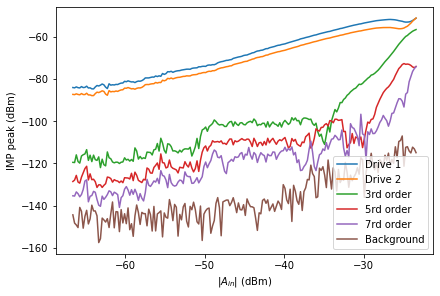

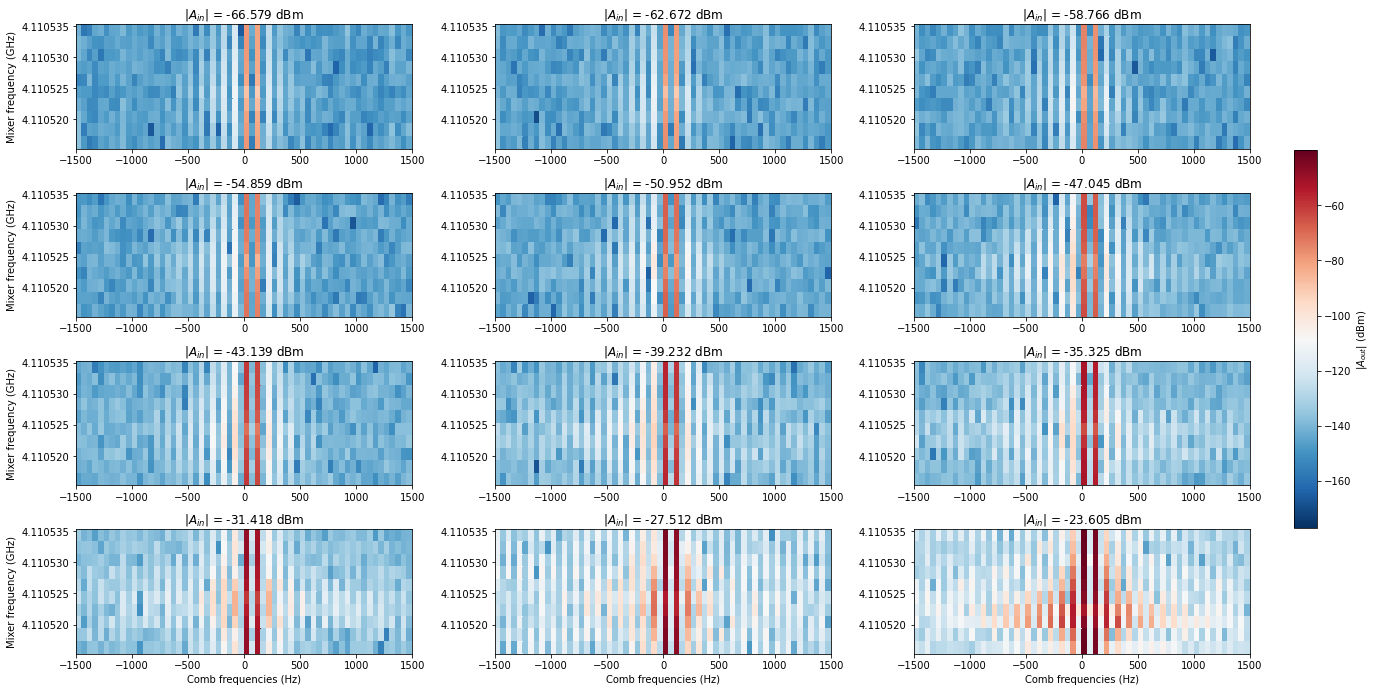

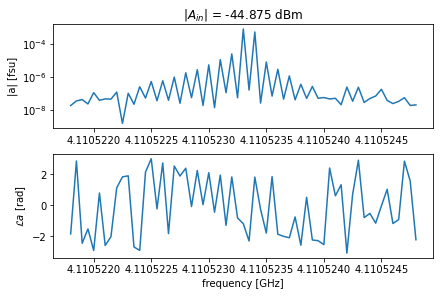

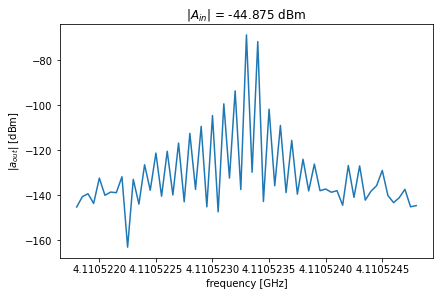

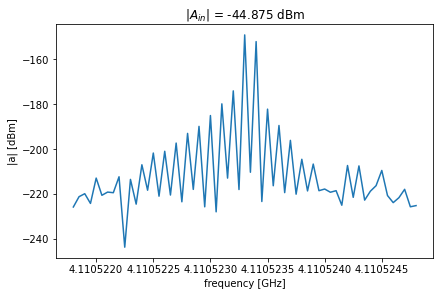

In [12]:
fNCO_ind = 6
amp_ind = 100

# IMP vs output power
fig, ax = plt.subplots(1)
ax.plot(pamp_dBm_arr, dBm(np.abs(spectrum_arr[fNCO_ind, :, 30])), '-', label='Drive 1')
ax.plot(pamp_dBm_arr, dBm(np.abs(spectrum_arr[fNCO_ind, :, 32])), '-', label='Drive 2')
ax.plot(pamp_dBm_arr, dBm(np.abs(spectrum_arr[fNCO_ind, :, 34])), label='3rd order')
ax.plot(pamp_dBm_arr, dBm(np.abs(spectrum_arr[fNCO_ind, :, 36])), label='5rd order')
ax.plot(pamp_dBm_arr, dBm(np.abs(spectrum_arr[fNCO_ind, :, 38])), label='7rd order')
ax.plot(pamp_dBm_arr, dBm(np.abs(spectrum_arr[fNCO_ind, :, -1])), label='Background')
ax.set_xlabel(r'|$A_{in}$| (dBm)')
ax.set_ylabel('IMP peak (dBm)')
ax.legend()

# 2D plot of the signal amplitude as a function of the mixer frequency and the comb frequency
fig2, ax2 = plt.subplots(4, 3, figsize=[19, 9.5], constrained_layout=True)
ax2 = ax2.flatten()
zmax = np.max(dBm(np.abs(spectrum_arr)))
zmin = np.min(dBm(np.abs(spectrum_arr)))
for axi in range(4 * 3):
    amp_ind_ = axi
    if file == r'D:\TLS\TLS-Data\TLS_IMP_amped_DCAW23_200amps_11points.hdf5':
        amp_ind_ = int(len(pamp_arr) / 11) * axi
    a = ax2[axi].pcolormesh(comb_freqs,
                            fNCO_arr / 1e9,
                            dBm(np.abs(spectrum_arr))[:, amp_ind_, :],
                            cmap='RdBu_r',
                            vmax=zmax,
                            vmin=zmin,
                            )
    ax2[axi].set_title(r'|$A_{in}$|' + f' = {pamp_dBm_arr[amp_ind_]:.3f} dBm')
fig.colorbar(a, ax=ax2[:], location='right', label=r'|$A_{out}$| (dBm)', shrink=0.6)
[ax2[axi].set_xlabel('Comb frequencies (Hz)') for axi in [9, 10, 11]]
[ax2[axi].set_ylabel('Mixer frequency (GHz)') for axi in [0, 3, 6, 9]]

# Experimental spectrum at a given power and mixer frequency
fig, ax = plt.subplots(2)
ax[0].semilogy((comb_freqs + fNCO_arr[fNCO_ind]) / 1e9, np.abs(spectrum_arr[fNCO_ind, amp_ind, :]))
ax[1].plot((comb_freqs + fNCO_arr[fNCO_ind]) / 1e9, np.angle(spectrum_arr[fNCO_ind, amp_ind, :]))
ax[0].set_title(r'|$A_{in}$|' + f' = {pamp_dBm_arr[amp_ind]:.3f} dBm')
ax[0].set_ylabel('|a| [fsu]')
ax[1].set_ylabel('$\mathcal{L} a $ [rad]')
ax[1].set_xlabel('frequency [GHz]')

# Spectrum at a given power and mixer frequency in dBm
fig, ax = plt.subplots(1)
ax.plot((comb_freqs+fNCO_arr[fNCO_ind])/1e9, dBm(np.abs(spectrum_arr[fNCO_ind, amp_ind, :])))
ax.set_title(r'|$A_{in}$|' + f' = {pamp_dBm_arr[amp_ind]:.3f} dBm')
ax.set_ylabel('|$a_{out}$| [dBm]')
ax.set_xlabel('frequency [GHz]')

# Input field in the resonator
pamp_intracavity_dBm = pamp_dBm_arr - att
pamp_intracavity_W = W(pamp_intracavity_dBm)

# Output field in the resonator
spectrum_intracavity_dBm = dBm(np.abs(spectrum_arr)) - gain
spectrum_intracavity_W = W(spectrum_intracavity_dBm)

# Intra-cavity spectrum at a given power and mixer frequency in dBm
fig, ax = plt.subplots(1)
ax.plot((comb_freqs+fNCO_arr[fNCO_ind])/1e9, spectrum_intracavity_dBm[fNCO_ind, amp_ind, :])
ax.set_title(r'|$A_{in}$|' + f' = {pamp_dBm_arr[amp_ind]:.3f} dBm')
ax.set_ylabel('|a| [dBm]')
ax.set_xlabel('frequency [GHz]')

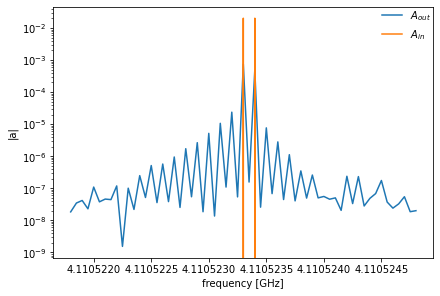

TypeError: recon_nonlinear() missing 1 required positional argument: 'order'

In [6]:
# %% Reconstruction

Aout = spectrum_arr[fNCO_ind, amp_ind, :]

drives_ind = np.array([30, 32])
Ain = np.zeros_like(Aout, dtype=np.complex)
Ain[drives_ind] = pamp_arr[amp_ind] * 1.0j

fig2, ax = plt.subplots(1)
ax.semilogy((comb_freqs + fNCO_arr[fNCO_ind]) / 1e9, np.abs(Aout), label='$A_{out}$')
ax.semilogy((comb_freqs + fNCO_arr[fNCO_ind]) / 1e9, np.abs(Ain), label='$A_{in}$')
ax.set_xlabel('frequency [GHz]')
ax.set_ylabel('|a|')
fig2.legend(frameon=False)
plt.show()

λ_recon, f0_recon, κ0_recon, κnl_recon, Q_fit, Q = recon_nonlinear(A=Aout,
                                                                   Ain=Ain,
                                                                   f=(comb_freqs + fNCO_arr[fNCO_ind]) / 1e9,
                                                                   gain=gain_lin,
                                                                   att=att_lin,
                                                                   )

print("f0_recon = {} GHz".format(f0_recon))
print("κ0_recon = {}".format(κ0_recon))
print("κ1_recon = {}".format(κnl_recon))
print("λ_recon = {}".format(λ_recon))
print("----------------------------------")